In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
import random
from matplotlib import pyplot as plt
from pair_trading_foundations.data_generation import ExecutePairTrading, generate_training_data
random.seed(23)
import cProfile
import pstats

/var/folders/f4/28wskrvx4yz7gqswwx15x1bh0000gn/T/ipykernel_10518/3080375706.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('Data/sp500_full_20181231_to_20231229.csv')

In [ ]:
value_count_tb = data[['Ticker']].groupby('Ticker').size().reset_index()
value_count_tb.columns = ['Ticker', 'Count']
stock_to_keep = value_count_tb['Ticker'][value_count_tb.Count==value_count_tb.Count.max()]
data = data[data.Ticker.isin(stock_to_keep)]

sampled_tickers = random.sample(list(stock_to_keep.values), 200)

data_tech = data[data['GICS Sector'].isin(['Information Technology'])]
data_sampled = data[data['Ticker'].isin(sampled_tickers)]

# Get the tech sector only

In [ ]:
recorded_info_tb, features_tb, labels_tb = generate_training_data(
        data=data_tech,
        training_len=500,
        test_len=120,
        sample_size_per_pair=10
    )

In [ ]:
combined = pd.merge(recorded_info_tb, features_tb, how='inner', on= ['ticker1','ticker2', 'target_date'])
combined = pd.merge(combined,labels_tb, how='inner', on= ['ticker1','ticker2', 'target_date'] )

In [ ]:
combined.to_csv('Data/tech_sector_pairs.csv', index=False)

# Get sampled combs

In [ ]:
recorded_info_tb, features_tb, labels_tb = generate_training_data(
        data=data_sampled,
        training_len=500,
        test_len=120,
        sample_size_per_pair=10
    )

In [ ]:
combined = pd.merge(recorded_info_tb, features_tb, how='inner', on= ['ticker1','ticker2', 'target_date'])
combined = pd.merge(combined,labels_tb, how='inner', on= ['ticker1','ticker2', 'target_date'] )
combined.to_csv('Data/sampled_sector_pairs_200.csv', index=False)

# Examining

In [26]:
combined = pd.read_csv('Data/sampled_sector_pairs_200.csv')

In [28]:
combined.total_pnl.describe()

count    207676.000000
mean          0.006757
std           0.466689
min         -37.861598
25%          -0.003950
50%           0.000000
75%           0.016097
max          23.016912
Name: total_pnl, dtype: float64

In [29]:
combined[combined.total_pnl>21]

,ticker1,ticker2,target_date,abs_spread_mean,abs_spread_std,abs_spread_mean_l28,abs_spread_std_l28,same_sector_flag,same_sub_industry_flag,cos_sim,corr_coef,abs_spread_normed_max,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,total_pnl,total_pnl_l28_mean_std
61706,BKNG,F,2021-12-01,1994.916603,330.774518,2389.568579,125.875981,True,False,0.974361,0.872647,2.559709,1.572870,1.132254,0.844710,0.707190,0.985483,22.065485,9.593977
61707,BKNG,F,2021-10-13,1963.013843,311.235930,2377.410025,65.869321,True,False,0.983061,0.896185,2.617898,1.598196,1.136403,0.800470,1.547261,1.518131,21.976154,8.050768
62840,BKNG,VTRS,2021-10-25,1963.062542,320.267401,2417.505384,56.583791,False,False,0.973652,-0.211089,2.580851,1.589182,1.139216,0.812149,1.495318,1.502045,23.016912,8.817519


In [37]:
ticker1 = 'BKNG'
ticker2 = 'F'
# Get a list of unique dates for later use
all_dates = data['Date'].unique()
vec1_full = data['Close'][data.Ticker==ticker1].values
vec2_full = data['Close'][data.Ticker==ticker2].values

In [38]:
idx = np.where(all_dates=='2021-12-01')[0][0]

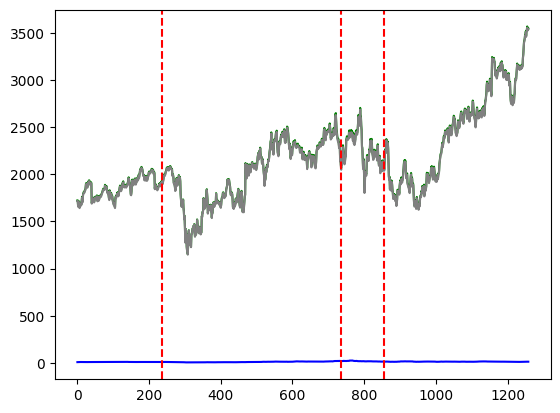

In [39]:
plt.plot(vec1_full, label='Stock1', color='green')
plt.plot(vec2_full, label='Stock2', color='blue')
plt.plot(abs(vec1_full - vec2_full), label='Absolute Spread', color='grey')
plt.axvline(x=idx, color='red', linestyle='--', label='Vertical Line')
plt.axvline(x=idx-500, color='red', linestyle='--', label='Vertical Line')
plt.axvline(x=idx+120, color='red', linestyle='--', label='Vertical Line')

In [40]:
trade = ExecutePairTrading(
    abs_spread_mean=1994.916603,
    abs_spread_std=330.774518
).execute(
vec1=vec1_full[idx:(idx+120)],
    vec2=vec2_full[idx:(idx+120)]
)

In [41]:
trade.trade_execution_table

,exit_idx,entry_idx,stock1_price_entry,stock1_price_exit,stock2_price_entry,stock2_price_exit,long_stock_1,pnl
0,65,48,2626.97998,1817.160034,18.35,15.97,False,2206.548514


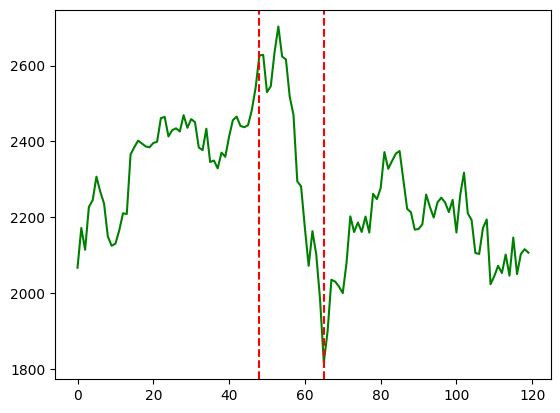

In [44]:
plt.plot(vec1_full[idx:(idx+120)], label='Stock1', color='green')
# plt.plot(vec2_full[idx:(idx+120)], label='Stock2', color='blue')
plt.axvline(x=48, color='red', linestyle='--', label='Vertical Line')
plt.axvline(x=65, color='red', linestyle='--', label='Vertical Line')

In [ ]:
trade.final_pl_pct

In [ ]:
trade.final_pl